## Task:
Get hands-on experience with training a shallow neural network (1- or 2-hidden layers only) on a small but adjustable problem.

## Software:

You may find the necessary function references here:

https://pytorch.org/docs/stable/torch.html

## Mount your files (not needed for this homework)

In [ ]:
#Add in the future if you need to transfer data

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Include the necessary libraries

In [ ]:
#import pytorch
import torch
import torch.optim as optim

#for plotting the learning curve
import matplotlib.pyplot as plt

import random
import numpy as np

from tqdm import tqdm
import itertools

## Hyperparameters

In [ ]:
# f                 = 2       # target function frequency
# max_epochs        = 200_000 # maximum number of epochs
# hiddensize        = 50        # number of hidden layers for your network
# lr                = 1e-4        # learning rate
# momentum          = 0.9        # momentum parameter for SGD optimizer
# num_hidden_layers = 2        # number of hidden layers

In [ ]:
f = 2                                       # target function frequency
max_epochs = 200_000                        # maximum number of epochs

# defining ranges for hyperparameters
hiddensizes = [25, 50, 100]                 # number of hidden layers for your network
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]   # learning rate
momentums = [0.9, 0]                        # momentum parameter for SGD optimizer -- 0 is SGD's default momentum
num_hidden_layers = [1, 2]                  # number of hidden layers

In [ ]:
# creating lists of all possible combinations for both SGD and Adam optimizer
hparam_list_sgd = list(itertools.product(hiddensizes, learning_rates, num_hidden_layers, momentums))
hparam_list_adam = list(itertools.product(hiddensizes, learning_rates, num_hidden_layers))

In [ ]:
# number of possible combinations
len(hparam_list_sgd) + len(hparam_list_adam)

72

## Set a random seed for reproducibility

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Generate and plot the data

tensor([[37.4540],
        [95.0714],
        [73.1994],
        [59.8658],
        [15.6019]])
tensor([[-1.0000],
        [-0.5854],
        [ 0.2289],
        [ 0.9445],
        [ 0.9254]])


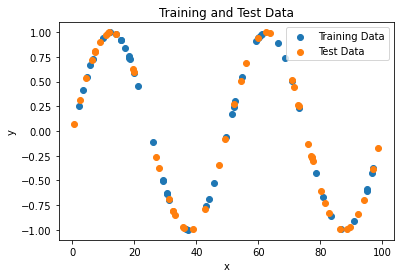

In [ ]:
def return_data(num_samples):
    '''
    Function generates num_samples many instances of (x, sin(2 * pi * f * x)) pairs
    '''
    x = torch.Tensor(np.random.rand(num_samples, 1) * 100)
    y = np.sin(2 * 3.14 * f / 100 * x)
    return x, y


# Set the number of instances
num_train = 50
num_test = 50

# Generate train and test data
x_train, y_train = return_data(num_train)
x_test, y_test = return_data(num_test)

# Show first 5 instances
print(x_train[:5])
print(y_train[:5])

# Plot the training data
plt.scatter(x_train.numpy(), y_train.numpy(), label='Training Data')

# Plot the test data
plt.scatter(x_test.numpy(), y_test.numpy(), label='Test Data')

plt.title("Training and Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Design a neural network

In [ ]:
# Define the neural network architecture
class Net(torch.nn.Module):
    def __init__(self, hidden_dimension, num_hidden_layers):
        super(Net, self).__init__()
        # input layer
        # B x 1 -> B x hidden_dimension (with a ReLU nonlinearity at the end)
        self.input = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dimension),
            torch.nn.ReLU()
        ) # add a sequential layer that contains a Linear layer and ReLU respectively

        # hidden layers
        # B x hidden_dimension -> B x hidden_dimension (with a ReLU nonlinearity at the end) repeated num_hidden_layers many times
        self.hiddens = torch.nn.ModuleList(
            [
                torch.nn.Sequential(
                    torch.nn.Linear(hidden_dimension, hidden_dimension),
                    torch.nn.ReLU()
                )
                for num in range(num_hidden_layers)
            ]
        ) # add a ModuleList that contains num_hidden_layers many sequential layers each having one Linear layer and one ReLU

        # output layer
        # B x hidden_dimension -> B x 1
        self.output = torch.nn.Linear(hidden_dimension, 1) # add a Linear layer

    def forward(self, x):
        x = self.input(x)
        for hidden in self.hiddens:
            x = hidden(x)
        x = self.output(x)
        return x


## Create a network, loss function and optimizer

In [ ]:
# function for network, loss func and optimizer initializations

# takes hiddensize, number of hidden layers, desired optimizer as str,
# learning rate and momentum as input parameters to use in inits

# returns created network, objective and optimizer

def create_net_loss_optim(
    hiddensize,
    num_hidden_layers,
    desired_optimizer,
    lr,
    momentum=0.0):

    # Create the neural network and specify the loss function and optimizer
    net = Net(hiddensize, num_hidden_layers)# create a network with hidden_dimension and num_hidden_layers

    criterion = torch.nn.MSELoss() # objective to minimize

    if desired_optimizer == "adam":
        optimizer = torch.optim.Adam(net.parameters(), lr=lr) # choose and create an optimizer (SGD, SGD with momentum, or ADAM)
    else: # if the desired optimizer is SGD
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    return net, criterion, optimizer

## Training loop

In [ ]:
# function for training

# takes train dataset, objective to minimize, optimizer and model as inputs

# returns calculated train losses, validation losses, number of epochs that
# model was trained on and the final model

def _train(x_train, y_train, criterion, optimizer, model):

    # Train the neural network

    # Set the desired error threshold
    # acceptable for the sine function
    error_threshold = 0.001

    # To display the learning curve
    losses = []
    vallosses = []

    epoch = 0

    while epoch < max_epochs:
        epoch += 1

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_train)

        # Compute the loss
        loss = criterion(y_pred, y_train)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


        # Make an evaluation on the test set every 100 epochs
        if epoch % 100 == 0:

            losses.append(loss.item())

            # Test the neural network with val data
            with torch.no_grad():
                y_pred = model(x_test)

            valloss = criterion(y_pred, y_test) # loss in the test set
            vallosses.append(valloss.item())

            # Print the loss every 1000 epochs
            if epoch % 10000 == 0:
                print("Epoch {}: Loss = {}".format(epoch, loss.item()))
                print('\nValidation loss:', valloss, '\n')

            # Check if the error is below the threshold
            if loss < error_threshold or epoch > 200000:
                break

    return losses, vallosses, epoch, model

    #end of the epoch loop ------------------------------------------------

    # Plot the learning curve
    # plt.plot(losses)
    # plt.plot(vallosses)
    # plt.title("Learning Curve")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.show()

### trainings with various configurations

In [ ]:
# list for saving the test results

results = []

####sgd

In [ ]:
hparam_list_sgd[0]

(25, 0.01, 1, 0.9)

In [ ]:
# loop for possible hyperparameter combinations with SGD optimizer

# iterates over possible combinations of hidden size, learning rate, number of hidden layers and momentum

for hsize, lr, num_hidden_lay, momentum in tqdm(hparam_list_sgd):
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    model, criterion, optimizer = create_net_loss_optim(hsize, num_hidden_lay, "sgd", lr, momentum)
    losses, vallosses, epoch, _ = _train(x_train, y_train, criterion, optimizer, model)

    results.append(
        {
            "num_hidden_layer": num_hidden_lay,
            "hiddensize": hsize,
            "lr": lr,
            "optimizer": "SGD",
            "momentum": momentum,
            "epoch": epoch,
            "train_loss": losses,
            "val_loss": vallosses,
        }
    )

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10000: Loss = nan

Validation loss: tensor(nan) 

Epoch 20000: Loss = nan

Validation loss: tensor(nan) 

Epoch 30000: Loss = nan

Validation loss: tensor(nan) 

Epoch 40000: Loss = nan

Validation loss: tensor(nan) 

Epoch 50000: Loss = nan

Validation loss: tensor(nan) 

Epoch 60000: Loss = nan

Validation loss: tensor(nan) 

Epoch 70000: Loss = nan

Validation loss: tensor(nan) 

Epoch 80000: Loss = nan

Validation loss: tensor(nan) 

Epoch 90000: Loss = nan

Validation loss: tensor(nan) 

Epoch 100000: Loss = nan

Validation loss: tensor(nan) 

Epoch 110000: Loss = nan

Validation loss: tensor(nan) 

Epoch 120000: Loss = nan

Validation loss: tensor(nan) 

Epoch 130000: Loss = nan

Validation loss: tensor(nan) 

Epoch 140000: Loss = nan

Validation loss: tensor(nan) 

Epoch 150000: Loss = nan

Validation loss: tensor(nan) 

Epoch 160000: Loss = nan

Validation loss: tensor(nan) 

Epoch 170000: Loss = nan

Validation loss: tensor(nan) 

Epoch 180000: Loss = nan

Validation los

  2%|▏         | 1/48 [02:02<1:36:19, 122.96s/it]

Epoch 200000: Loss = nan

Validation loss: tensor(nan) 

Epoch 10000: Loss = nan

Validation loss: tensor(nan) 

Epoch 20000: Loss = nan

Validation loss: tensor(nan) 

Epoch 30000: Loss = nan

Validation loss: tensor(nan) 

Epoch 40000: Loss = nan

Validation loss: tensor(nan) 

Epoch 50000: Loss = nan

Validation loss: tensor(nan) 

Epoch 60000: Loss = nan

Validation loss: tensor(nan) 

Epoch 70000: Loss = nan

Validation loss: tensor(nan) 

Epoch 80000: Loss = nan

Validation loss: tensor(nan) 

Epoch 90000: Loss = nan

Validation loss: tensor(nan) 

Epoch 100000: Loss = nan

Validation loss: tensor(nan) 

Epoch 110000: Loss = nan

Validation loss: tensor(nan) 

Epoch 120000: Loss = nan

Validation loss: tensor(nan) 

Epoch 130000: Loss = nan

Validation loss: tensor(nan) 

Epoch 140000: Loss = nan

Validation loss: tensor(nan) 

Epoch 150000: Loss = nan

Validation loss: tensor(nan) 

Epoch 160000: Loss = nan

Validation loss: tensor(nan) 

Epoch 170000: Loss = nan

Validation los

  4%|▍         | 2/48 [03:38<1:22:02, 107.01s/it]

Epoch 200000: Loss = nan

Validation loss: tensor(nan) 

Epoch 10000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 20000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 30000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 40000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 60000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 70000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 80000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 100000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 110000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 120000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 130000: Loss = 0.48075035214424133

  6%|▋         | 3/48 [05:55<1:30:33, 120.74s/it]

Epoch 200000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 10000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 20000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 30000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 40000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 60000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 70000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 80000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 100000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 110000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 120000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 130000: Loss = 

  8%|▊         | 4/48 [07:49<1:26:31, 117.98s/it]

Epoch 200000: Loss = 0.48075035214424133

Validation loss: tensor(0.5152) 

Epoch 10000: Loss = 0.3945022523403168

Validation loss: tensor(0.3968) 

Epoch 20000: Loss = 0.39431554079055786

Validation loss: tensor(0.3928) 

Epoch 30000: Loss = 0.3942033350467682

Validation loss: tensor(0.3946) 

Epoch 40000: Loss = 0.39419448375701904

Validation loss: tensor(0.3946) 

Epoch 50000: Loss = 0.39419329166412354

Validation loss: tensor(0.3946) 

Epoch 60000: Loss = 0.39419281482696533

Validation loss: tensor(0.3946) 

Epoch 70000: Loss = 0.39419272541999817

Validation loss: tensor(0.3946) 

Epoch 80000: Loss = 0.39419615268707275

Validation loss: tensor(0.3950) 

Epoch 90000: Loss = 0.3941938877105713

Validation loss: tensor(0.3948) 

Epoch 100000: Loss = 0.39419347047805786

Validation loss: tensor(0.3948) 

Epoch 110000: Loss = 0.3941933512687683

Validation loss: tensor(0.3947) 

Epoch 120000: Loss = 0.3941928446292877

Validation loss: tensor(0.3946) 

Epoch 130000: Loss = 0.394

 10%|█         | 5/48 [09:40<1:22:48, 115.56s/it]

Epoch 200000: Loss = 0.39419278502464294

Validation loss: tensor(0.3946) 

Epoch 10000: Loss = 0.36001941561698914

Validation loss: tensor(0.3554) 

Epoch 20000: Loss = 0.34247997403144836

Validation loss: tensor(0.3392) 

Epoch 30000: Loss = 0.32101118564605713

Validation loss: tensor(0.3141) 

Epoch 40000: Loss = 0.3102777302265167

Validation loss: tensor(0.2997) 

Epoch 50000: Loss = 0.309563547372818

Validation loss: tensor(0.2967) 

Epoch 60000: Loss = 0.3093684911727905

Validation loss: tensor(0.2962) 

Epoch 70000: Loss = 0.3093079626560211

Validation loss: tensor(0.2960) 

Epoch 80000: Loss = 0.30927976965904236

Validation loss: tensor(0.2959) 

Epoch 90000: Loss = 0.30925747752189636

Validation loss: tensor(0.2958) 

Epoch 100000: Loss = 0.3092357814311981

Validation loss: tensor(0.2957) 

Epoch 110000: Loss = 0.3092096447944641

Validation loss: tensor(0.2957) 

Epoch 120000: Loss = 0.30918699502944946

Validation loss: tensor(0.2956) 

Epoch 130000: Loss = 0.30916

 12%|█▎        | 6/48 [11:15<1:15:59, 108.57s/it]

Epoch 200000: Loss = 0.30906689167022705

Validation loss: tensor(0.2953) 

Epoch 10000: Loss = 0.30794334411621094

Validation loss: tensor(0.2933) 

Epoch 20000: Loss = 0.3078967034816742

Validation loss: tensor(0.2932) 

Epoch 30000: Loss = 0.30789467692375183

Validation loss: tensor(0.2932) 

Epoch 40000: Loss = 0.30789321660995483

Validation loss: tensor(0.2932) 

Epoch 50000: Loss = 0.3078921139240265

Validation loss: tensor(0.2932) 

Epoch 60000: Loss = 0.3078910708427429

Validation loss: tensor(0.2932) 

Epoch 70000: Loss = 0.307890385389328

Validation loss: tensor(0.2932) 

Epoch 80000: Loss = 0.30788958072662354

Validation loss: tensor(0.2932) 

Epoch 90000: Loss = 0.30788901448249817

Validation loss: tensor(0.2932) 

Epoch 100000: Loss = 0.30788856744766235

Validation loss: tensor(0.2932) 

Epoch 110000: Loss = 0.30788829922676086

Validation loss: tensor(0.2932) 

Epoch 120000: Loss = 0.30788809061050415

Validation loss: tensor(0.2932) 

Epoch 130000: Loss = 0.307

 15%|█▍        | 7/48 [13:29<1:19:40, 116.59s/it]

Epoch 200000: Loss = 0.30788758397102356

Validation loss: tensor(0.2932) 

Epoch 10000: Loss = 0.3693407475948334

Validation loss: tensor(0.3630) 

Epoch 20000: Loss = 0.340862512588501

Validation loss: tensor(0.3482) 

Epoch 30000: Loss = 0.2557228207588196

Validation loss: tensor(0.2665) 

Epoch 40000: Loss = 0.21549850702285767

Validation loss: tensor(0.3563) 

Epoch 50000: Loss = 0.19760024547576904

Validation loss: tensor(0.1123) 

Epoch 60000: Loss = 0.06089398264884949

Validation loss: tensor(0.0822) 

Epoch 70000: Loss = 0.050598446279764175

Validation loss: tensor(0.0638) 

Epoch 80000: Loss = 0.04559004679322243

Validation loss: tensor(0.0689) 

Epoch 90000: Loss = 0.07980319857597351

Validation loss: tensor(0.0658) 

Epoch 100000: Loss = 0.03595271334052086

Validation loss: tensor(0.0631) 

Epoch 110000: Loss = 0.028247861191630363

Validation loss: tensor(0.0475) 

Epoch 120000: Loss = 0.0373493991792202

Validation loss: tensor(0.0688) 

Epoch 130000: Loss = 0.0

 17%|█▋        | 8/48 [15:21<1:16:54, 115.37s/it]

Epoch 200000: Loss = 0.027267005294561386

Validation loss: tensor(0.0476) 

Epoch 10000: Loss = 0.3969607949256897

Validation loss: tensor(0.4008) 

Epoch 20000: Loss = 0.39688706398010254

Validation loss: tensor(0.4006) 

Epoch 30000: Loss = 0.39681997895240784

Validation loss: tensor(0.4004) 

Epoch 40000: Loss = 0.39673805236816406

Validation loss: tensor(0.4002) 

Epoch 50000: Loss = 0.3966215252876282

Validation loss: tensor(0.4001) 

Epoch 60000: Loss = 0.39649704098701477

Validation loss: tensor(0.3999) 

Epoch 70000: Loss = 0.39637523889541626

Validation loss: tensor(0.3996) 

Epoch 80000: Loss = 0.3962542712688446

Validation loss: tensor(0.3994) 

Epoch 90000: Loss = 0.39612847566604614

Validation loss: tensor(0.3991) 

Epoch 100000: Loss = 0.39599892497062683

Validation loss: tensor(0.3988) 

Epoch 110000: Loss = 0.395865261554718

Validation loss: tensor(0.3986) 

Epoch 120000: Loss = 0.3957260549068451

Validation loss: tensor(0.3983) 

Epoch 130000: Loss = 0.395

 19%|█▉        | 9/48 [17:09<1:13:27, 113.02s/it]

Epoch 200000: Loss = 0.39463168382644653

Validation loss: tensor(0.3960) 

Epoch 10000: Loss = 0.39433783292770386

Validation loss: tensor(0.3892) 

Epoch 20000: Loss = 0.3833038806915283

Validation loss: tensor(0.3830) 

Epoch 30000: Loss = 0.37971627712249756

Validation loss: tensor(0.3803) 

Epoch 40000: Loss = 0.3765382468700409

Validation loss: tensor(0.3769) 

Epoch 50000: Loss = 0.37340420484542847

Validation loss: tensor(0.3737) 

Epoch 60000: Loss = 0.3705175817012787

Validation loss: tensor(0.3697) 

Epoch 70000: Loss = 0.3680132031440735

Validation loss: tensor(0.3665) 

Epoch 80000: Loss = 0.36596810817718506

Validation loss: tensor(0.3637) 

Epoch 90000: Loss = 0.36423835158348083

Validation loss: tensor(0.3614) 

Epoch 100000: Loss = 0.36302316188812256

Validation loss: tensor(0.3597) 

Epoch 110000: Loss = 0.36219435930252075

Validation loss: tensor(0.3582) 

Epoch 120000: Loss = 0.3615591526031494

Validation loss: tensor(0.3582) 

Epoch 130000: Loss = 0.361

 21%|██        | 10/48 [18:42<1:07:43, 106.94s/it]

Epoch 200000: Loss = 0.36033231019973755

Validation loss: tensor(0.3563) 

Epoch 10000: Loss = 0.38546642661094666

Validation loss: tensor(0.3859) 

Epoch 20000: Loss = 0.3546034097671509

Validation loss: tensor(0.3526) 

Epoch 30000: Loss = 0.26704952120780945

Validation loss: tensor(0.2828) 

Epoch 40000: Loss = 0.08833051472902298

Validation loss: tensor(0.1017) 

Epoch 50000: Loss = 0.03244292736053467

Validation loss: tensor(0.0513) 

Epoch 60000: Loss = 0.02521095983684063

Validation loss: tensor(0.0394) 

Epoch 70000: Loss = 0.018956512212753296

Validation loss: tensor(0.0306) 

Epoch 80000: Loss = 0.013302160426974297

Validation loss: tensor(0.0238) 

Epoch 90000: Loss = 0.04527048021554947

Validation loss: tensor(0.0734) 

Epoch 100000: Loss = 0.04520369693636894

Validation loss: tensor(0.0732) 

Epoch 110000: Loss = 0.04517892003059387

Validation loss: tensor(0.0731) 

Epoch 120000: Loss = 0.04516470804810524

Validation loss: tensor(0.0725) 

Epoch 130000: Loss =

 23%|██▎       | 11/48 [20:53<1:10:19, 114.04s/it]

Epoch 200000: Loss = 0.04214119911193848

Validation loss: tensor(0.0686) 

Epoch 10000: Loss = 0.4019466042518616

Validation loss: tensor(0.3982) 

Epoch 20000: Loss = 0.39480772614479065

Validation loss: tensor(0.3949) 

Epoch 30000: Loss = 0.3934076428413391

Validation loss: tensor(0.3946) 

Epoch 40000: Loss = 0.3925034999847412

Validation loss: tensor(0.3940) 

Epoch 50000: Loss = 0.39155828952789307

Validation loss: tensor(0.3932) 

Epoch 60000: Loss = 0.3904871344566345

Validation loss: tensor(0.3920) 

Epoch 70000: Loss = 0.38925403356552124

Validation loss: tensor(0.3907) 

Epoch 80000: Loss = 0.38783589005470276

Validation loss: tensor(0.3892) 

Epoch 90000: Loss = 0.38620367646217346

Validation loss: tensor(0.3874) 

Epoch 100000: Loss = 0.38433465361595154

Validation loss: tensor(0.3854) 

Epoch 110000: Loss = 0.38217881321907043

Validation loss: tensor(0.3830) 

Epoch 120000: Loss = 0.37970274686813354

Validation loss: tensor(0.3804) 

Epoch 130000: Loss = 0.37

 25%|██▌       | 12/48 [22:44<1:07:52, 113.13s/it]

Epoch 200000: Loss = 0.3472211956977844

Validation loss: tensor(0.3466) 

Epoch 10000: Loss = 0.3943589925765991

Validation loss: tensor(0.3891) 

Epoch 20000: Loss = 0.3833223283290863

Validation loss: tensor(0.3832) 

Epoch 30000: Loss = 0.3797168433666229

Validation loss: tensor(0.3805) 

Epoch 40000: Loss = 0.37650954723358154

Validation loss: tensor(0.3771) 

Epoch 50000: Loss = 0.3733968436717987

Validation loss: tensor(0.3734) 

Epoch 60000: Loss = 0.3705131411552429

Validation loss: tensor(0.3699) 

Epoch 70000: Loss = 0.367976576089859

Validation loss: tensor(0.3666) 

Epoch 80000: Loss = 0.36588069796562195

Validation loss: tensor(0.3640) 

Epoch 90000: Loss = 0.3642192780971527

Validation loss: tensor(0.3618) 

Epoch 100000: Loss = 0.36298447847366333

Validation loss: tensor(0.3600) 

Epoch 110000: Loss = 0.3620983064174652

Validation loss: tensor(0.3587) 

Epoch 120000: Loss = 0.361487478017807

Validation loss: tensor(0.3578) 

Epoch 130000: Loss = 0.3610736727

 27%|██▋       | 13/48 [24:29<1:04:39, 110.86s/it]

Epoch 200000: Loss = 0.3603074550628662

Validation loss: tensor(0.3548) 

Epoch 10000: Loss = 0.4666981101036072

Validation loss: tensor(0.4461) 

Epoch 20000: Loss = 0.44986265897750854

Validation loss: tensor(0.4321) 

Epoch 30000: Loss = 0.4365675747394562

Validation loss: tensor(0.4211) 

Epoch 40000: Loss = 0.42605820298194885

Validation loss: tensor(0.4128) 

Epoch 50000: Loss = 0.4177328944206238

Validation loss: tensor(0.4063) 

Epoch 60000: Loss = 0.4108700156211853

Validation loss: tensor(0.4005) 

Epoch 70000: Loss = 0.40525463223457336

Validation loss: tensor(0.3963) 

Epoch 80000: Loss = 0.40078040957450867

Validation loss: tensor(0.3932) 

Epoch 90000: Loss = 0.39721620082855225

Validation loss: tensor(0.3908) 

Epoch 100000: Loss = 0.39433151483535767

Validation loss: tensor(0.3891) 

Epoch 110000: Loss = 0.39202407002449036

Validation loss: tensor(0.3877) 

Epoch 120000: Loss = 0.3901703655719757

Validation loss: tensor(0.3866) 

Epoch 130000: Loss = 0.3886

 29%|██▉       | 14/48 [26:01<59:35, 105.17s/it]  

Epoch 200000: Loss = 0.38328734040260315

Validation loss: tensor(0.3832) 

Epoch 10000: Loss = 0.40186169743537903

Validation loss: tensor(0.3981) 

Epoch 20000: Loss = 0.3947747051715851

Validation loss: tensor(0.3948) 

Epoch 30000: Loss = 0.3934456706047058

Validation loss: tensor(0.3946) 

Epoch 40000: Loss = 0.39268606901168823

Validation loss: tensor(0.3941) 

Epoch 50000: Loss = 0.3919001817703247

Validation loss: tensor(0.3934) 

Epoch 60000: Loss = 0.3910124599933624

Validation loss: tensor(0.3924) 

Epoch 70000: Loss = 0.38999393582344055

Validation loss: tensor(0.3912) 

Epoch 80000: Loss = 0.38882365822792053

Validation loss: tensor(0.3899) 

Epoch 90000: Loss = 0.3874841332435608

Validation loss: tensor(0.3884) 

Epoch 100000: Loss = 0.3859573006629944

Validation loss: tensor(0.3866) 

Epoch 110000: Loss = 0.3842198848724365

Validation loss: tensor(0.3846) 

Epoch 120000: Loss = 0.3822484612464905

Validation loss: tensor(0.3824) 

Epoch 130000: Loss = 0.380031

 31%|███▏      | 15/48 [28:11<1:01:50, 112.45s/it]

Epoch 200000: Loss = 0.35788699984550476

Validation loss: tensor(0.3548) 

Epoch 10000: Loss = 0.44562870264053345

Validation loss: tensor(0.4316) 

Epoch 20000: Loss = 0.436535120010376

Validation loss: tensor(0.4241) 

Epoch 30000: Loss = 0.4288980960845947

Validation loss: tensor(0.4181) 

Epoch 40000: Loss = 0.42286550998687744

Validation loss: tensor(0.4135) 

Epoch 50000: Loss = 0.4178451597690582

Validation loss: tensor(0.4097) 

Epoch 60000: Loss = 0.41365230083465576

Validation loss: tensor(0.4064) 

Epoch 70000: Loss = 0.4085790514945984

Validation loss: tensor(0.4025) 

Epoch 80000: Loss = 0.4058705270290375

Validation loss: tensor(0.4007) 

Epoch 90000: Loss = 0.4036544859409332

Validation loss: tensor(0.3993) 

Epoch 100000: Loss = 0.4018426239490509

Validation loss: tensor(0.3981) 

Epoch 110000: Loss = 0.40036314725875854

Validation loss: tensor(0.3973) 

Epoch 120000: Loss = 0.3991550803184509

Validation loss: tensor(0.3966) 

Epoch 130000: Loss = 0.3981709

 33%|███▎      | 16/48 [30:00<59:33, 111.67s/it]  

Epoch 200000: Loss = 0.39479005336761475

Validation loss: tensor(0.3948) 

Epoch 10000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 20000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 30000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 40000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 60000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 70000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 80000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 100000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 110000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 120000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 130000: Loss = 

 35%|███▌      | 17/48 [31:57<58:28, 113.17s/it]

Epoch 200000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 10000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 20000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 30000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 40000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 60000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 70000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 80000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 100000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 110000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 120000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 130000: Loss = 

 38%|███▊      | 18/48 [33:33<53:57, 107.92s/it]

Epoch 200000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 10000: Loss = nan

Validation loss: tensor(nan) 

Epoch 20000: Loss = nan

Validation loss: tensor(nan) 

Epoch 30000: Loss = nan

Validation loss: tensor(nan) 

Epoch 40000: Loss = nan

Validation loss: tensor(nan) 

Epoch 50000: Loss = nan

Validation loss: tensor(nan) 

Epoch 60000: Loss = nan

Validation loss: tensor(nan) 

Epoch 70000: Loss = nan

Validation loss: tensor(nan) 

Epoch 80000: Loss = nan

Validation loss: tensor(nan) 

Epoch 90000: Loss = nan

Validation loss: tensor(nan) 

Epoch 100000: Loss = nan

Validation loss: tensor(nan) 

Epoch 110000: Loss = nan

Validation loss: tensor(nan) 

Epoch 120000: Loss = nan

Validation loss: tensor(nan) 

Epoch 130000: Loss = nan

Validation loss: tensor(nan) 

Epoch 140000: Loss = nan

Validation loss: tensor(nan) 

Epoch 150000: Loss = nan

Validation loss: tensor(nan) 

Epoch 160000: Loss = nan

Validation loss: tensor(nan) 

Epoch 170000: Loss = 

 40%|███▉      | 19/48 [35:54<57:01, 117.99s/it]

Epoch 200000: Loss = nan

Validation loss: tensor(nan) 

Epoch 10000: Loss = nan

Validation loss: tensor(nan) 

Epoch 20000: Loss = nan

Validation loss: tensor(nan) 

Epoch 30000: Loss = nan

Validation loss: tensor(nan) 

Epoch 40000: Loss = nan

Validation loss: tensor(nan) 

Epoch 50000: Loss = nan

Validation loss: tensor(nan) 

Epoch 60000: Loss = nan

Validation loss: tensor(nan) 

Epoch 70000: Loss = nan

Validation loss: tensor(nan) 

Epoch 80000: Loss = nan

Validation loss: tensor(nan) 

Epoch 90000: Loss = nan

Validation loss: tensor(nan) 

Epoch 100000: Loss = nan

Validation loss: tensor(nan) 

Epoch 110000: Loss = nan

Validation loss: tensor(nan) 

Epoch 120000: Loss = nan

Validation loss: tensor(nan) 

Epoch 130000: Loss = nan

Validation loss: tensor(nan) 

Epoch 140000: Loss = nan

Validation loss: tensor(nan) 

Epoch 150000: Loss = nan

Validation loss: tensor(nan) 

Epoch 160000: Loss = nan

Validation loss: tensor(nan) 

Epoch 170000: Loss = nan

Validation los

 42%|████▏     | 20/48 [37:50<54:48, 117.46s/it]

Epoch 200000: Loss = nan

Validation loss: tensor(nan) 

Epoch 10000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 20000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 30000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 40000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 60000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 70000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 80000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 100000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 110000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 120000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 130000: Loss = 0.48075035214424133

 44%|████▍     | 21/48 [39:48<52:49, 117.41s/it]

Epoch 200000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 10000: Loss = 0.3752475082874298

Validation loss: tensor(0.3724) 

Epoch 20000: Loss = 0.3426084518432617

Validation loss: tensor(0.3314) 

Epoch 30000: Loss = 0.3212376832962036

Validation loss: tensor(0.3000) 

Epoch 40000: Loss = 0.31018173694610596

Validation loss: tensor(0.2997) 

Epoch 50000: Loss = 0.30879881978034973

Validation loss: tensor(0.2954) 

Epoch 60000: Loss = 0.3084771931171417

Validation loss: tensor(0.2971) 

Epoch 70000: Loss = 0.3083515465259552

Validation loss: tensor(0.2976) 

Epoch 80000: Loss = 0.30823734402656555

Validation loss: tensor(0.2972) 

Epoch 90000: Loss = 0.30806267261505127

Validation loss: tensor(0.2964) 

Epoch 100000: Loss = 0.3079754114151001

Validation loss: tensor(0.2956) 

Epoch 110000: Loss = 0.3079609274864197

Validation loss: tensor(0.2958) 

Epoch 120000: Loss = 0.3079424202442169

Validation loss: tensor(0.2957) 

Epoch 130000: Loss = 0.307931

 46%|████▌     | 22/48 [41:24<48:06, 111.03s/it]

Epoch 200000: Loss = 0.30789411067962646

Validation loss: tensor(0.2950) 

Epoch 10000: Loss = 0.3079794943332672

Validation loss: tensor(0.2932) 

Epoch 20000: Loss = 0.30793723464012146

Validation loss: tensor(0.2932) 

Epoch 30000: Loss = 0.3079223930835724

Validation loss: tensor(0.2932) 

Epoch 40000: Loss = 0.30791690945625305

Validation loss: tensor(0.2932) 

Epoch 50000: Loss = 0.30791470408439636

Validation loss: tensor(0.2932) 

Epoch 60000: Loss = 0.3079133927822113

Validation loss: tensor(0.2932) 

Epoch 70000: Loss = 0.3079127371311188

Validation loss: tensor(0.2932) 

Epoch 80000: Loss = 0.30791234970092773

Validation loss: tensor(0.2932) 

Epoch 90000: Loss = 0.3079119622707367

Validation loss: tensor(0.2932) 

Epoch 100000: Loss = 0.3079116642475128

Validation loss: tensor(0.2932) 

Epoch 110000: Loss = 0.3079114854335785

Validation loss: tensor(0.2932) 

Epoch 120000: Loss = 0.3079115152359009

Validation loss: tensor(0.2932) 

Epoch 130000: Loss = 0.307911

 48%|████▊     | 23/48 [43:49<50:28, 121.16s/it]

Epoch 200000: Loss = 0.30791130661964417

Validation loss: tensor(0.2932) 

Epoch 10000: Loss = 0.336010217666626

Validation loss: tensor(0.3276) 

Epoch 20000: Loss = 0.3374214470386505

Validation loss: tensor(0.2873) 

Epoch 30000: Loss = 0.31621870398521423

Validation loss: tensor(0.2416) 

Epoch 40000: Loss = 0.16036327183246613

Validation loss: tensor(0.1646) 

Epoch 50000: Loss = 0.14753612875938416

Validation loss: tensor(0.1386) 

Epoch 60000: Loss = 0.07439848780632019

Validation loss: tensor(0.1163) 

Epoch 70000: Loss = 0.10235735028982162

Validation loss: tensor(0.1968) 

Epoch 80000: Loss = 0.03965653479099274

Validation loss: tensor(0.0556) 

Epoch 90000: Loss = 0.02683313563466072

Validation loss: tensor(0.0425) 

Epoch 100000: Loss = 0.032680444419384

Validation loss: tensor(0.0660) 

Epoch 110000: Loss = 0.08565881848335266

Validation loss: tensor(0.0501) 

Epoch 120000: Loss = 0.05856494605541229

Validation loss: tensor(0.0667) 

Epoch 130000: Loss = 0.052

 50%|█████     | 24/48 [45:45<47:54, 119.76s/it]

Epoch 200000: Loss = 0.03274333104491234

Validation loss: tensor(0.0415) 

Epoch 10000: Loss = 0.3643333315849304

Validation loss: tensor(0.3613) 

Epoch 20000: Loss = 0.3157128691673279

Validation loss: tensor(0.3007) 

Epoch 30000: Loss = 0.16319423913955688

Validation loss: tensor(0.1641) 

Epoch 40000: Loss = 0.05552869290113449

Validation loss: tensor(0.0730) 

Epoch 50000: Loss = 0.045537468045949936

Validation loss: tensor(0.0727) 

Epoch 60000: Loss = 0.045123565942049026

Validation loss: tensor(0.0734) 

Epoch 70000: Loss = 0.04508562386035919

Validation loss: tensor(0.0737) 

Epoch 80000: Loss = 0.045068465173244476

Validation loss: tensor(0.0738) 

Epoch 90000: Loss = 0.04504929482936859

Validation loss: tensor(0.0738) 

Epoch 100000: Loss = 0.045019183307886124

Validation loss: tensor(0.0738) 

Epoch 110000: Loss = 0.044969357550144196

Validation loss: tensor(0.0737) 

Epoch 120000: Loss = 0.04488622769713402

Validation loss: tensor(0.0736) 

Epoch 130000: Loss

 52%|█████▏    | 25/48 [47:38<45:08, 117.75s/it]

Epoch 200000: Loss = 0.03331582993268967

Validation loss: tensor(0.0549) 

Epoch 10000: Loss = 0.39678123593330383

Validation loss: tensor(0.3968) 

Epoch 20000: Loss = 0.3956519067287445

Validation loss: tensor(0.3973) 

Epoch 30000: Loss = 0.39556753635406494

Validation loss: tensor(0.3974) 

Epoch 40000: Loss = 0.3954956829547882

Validation loss: tensor(0.3973) 

Epoch 50000: Loss = 0.39541012048721313

Validation loss: tensor(0.3972) 

Epoch 60000: Loss = 0.39532187581062317

Validation loss: tensor(0.3971) 

Epoch 70000: Loss = 0.3952634334564209

Validation loss: tensor(0.3970) 

Epoch 80000: Loss = 0.39521294832229614

Validation loss: tensor(0.3969) 

Epoch 90000: Loss = 0.3951631486415863

Validation loss: tensor(0.3969) 

Epoch 100000: Loss = 0.39511585235595703

Validation loss: tensor(0.3968) 

Epoch 110000: Loss = 0.39506953954696655

Validation loss: tensor(0.3967) 

Epoch 120000: Loss = 0.3950248956680298

Validation loss: tensor(0.3966) 

Epoch 130000: Loss = 0.394

 54%|█████▍    | 26/48 [49:15<40:53, 111.51s/it]

Epoch 200000: Loss = 0.39472874999046326

Validation loss: tensor(0.3961) 

Epoch 10000: Loss = 0.3408741354942322

Validation loss: tensor(0.3368) 

Epoch 20000: Loss = 0.29419663548469543

Validation loss: tensor(0.2841) 

Epoch 30000: Loss = 0.2063467651605606

Validation loss: tensor(0.2026) 

Epoch 40000: Loss = 0.0632684975862503

Validation loss: tensor(0.0860) 

Epoch 50000: Loss = 0.05985831841826439

Validation loss: tensor(0.0853) 

Epoch 60000: Loss = 0.04257671535015106

Validation loss: tensor(0.0700) 

Epoch 70000: Loss = 0.042223431169986725

Validation loss: tensor(0.0698) 

Epoch 80000: Loss = 0.042175378650426865

Validation loss: tensor(0.0698) 

Epoch 90000: Loss = 0.04215696454048157

Validation loss: tensor(0.0696) 

Epoch 100000: Loss = 0.042146917432546616

Validation loss: tensor(0.0697) 

Epoch 110000: Loss = 0.04214012250304222

Validation loss: tensor(0.0695) 

Epoch 120000: Loss = 0.0421355776488781

Validation loss: tensor(0.0696) 

Epoch 130000: Loss = 0

 56%|█████▋    | 27/48 [51:39<42:22, 121.08s/it]

Epoch 200000: Loss = 0.042107176035642624

Validation loss: tensor(0.0694) 

Epoch 10000: Loss = 0.39648178219795227

Validation loss: tensor(0.3905) 

Epoch 20000: Loss = 0.3839469850063324

Validation loss: tensor(0.3818) 

Epoch 30000: Loss = 0.379013329744339

Validation loss: tensor(0.3773) 

Epoch 40000: Loss = 0.3741775155067444

Validation loss: tensor(0.3724) 

Epoch 50000: Loss = 0.36855098605155945

Validation loss: tensor(0.3664) 

Epoch 60000: Loss = 0.3625009059906006

Validation loss: tensor(0.3596) 

Epoch 70000: Loss = 0.35602110624313354

Validation loss: tensor(0.3514) 

Epoch 80000: Loss = 0.348739355802536

Validation loss: tensor(0.3436) 

Epoch 90000: Loss = 0.3405406177043915

Validation loss: tensor(0.3354) 

Epoch 100000: Loss = 0.3311837911605835

Validation loss: tensor(0.3252) 

Epoch 110000: Loss = 0.31938841938972473

Validation loss: tensor(0.3133) 

Epoch 120000: Loss = 0.3042910099029541

Validation loss: tensor(0.2981) 

Epoch 130000: Loss = 0.2863616

 58%|█████▊    | 28/48 [53:38<40:11, 120.55s/it]

Epoch 200000: Loss = 0.1106242835521698

Validation loss: tensor(0.1460) 

Epoch 10000: Loss = 0.3968634009361267

Validation loss: tensor(0.3967) 

Epoch 20000: Loss = 0.3955974876880646

Validation loss: tensor(0.3972) 

Epoch 30000: Loss = 0.39551734924316406

Validation loss: tensor(0.3973) 

Epoch 40000: Loss = 0.3954414427280426

Validation loss: tensor(0.3972) 

Epoch 50000: Loss = 0.3953559100627899

Validation loss: tensor(0.3971) 

Epoch 60000: Loss = 0.3952943682670593

Validation loss: tensor(0.3970) 

Epoch 70000: Loss = 0.395246684551239

Validation loss: tensor(0.3969) 

Epoch 80000: Loss = 0.3952001929283142

Validation loss: tensor(0.3969) 

Epoch 90000: Loss = 0.3951549232006073

Validation loss: tensor(0.3968) 

Epoch 100000: Loss = 0.3951109051704407

Validation loss: tensor(0.3968) 

Epoch 110000: Loss = 0.3950684070587158

Validation loss: tensor(0.3967) 

Epoch 120000: Loss = 0.3950270116329193

Validation loss: tensor(0.3966) 

Epoch 130000: Loss = 0.39498707652

 60%|██████    | 29/48 [55:30<37:19, 117.88s/it]

Epoch 200000: Loss = 0.3947472870349884

Validation loss: tensor(0.3962) 

Epoch 10000: Loss = 0.44205242395401

Validation loss: tensor(0.4284) 

Epoch 20000: Loss = 0.4256495237350464

Validation loss: tensor(0.4156) 

Epoch 30000: Loss = 0.4149262309074402

Validation loss: tensor(0.4077) 

Epoch 40000: Loss = 0.4079504907131195

Validation loss: tensor(0.4028) 

Epoch 50000: Loss = 0.40345704555511475

Validation loss: tensor(0.3999) 

Epoch 60000: Loss = 0.40058135986328125

Validation loss: tensor(0.3983) 

Epoch 70000: Loss = 0.3987666964530945

Validation loss: tensor(0.3974) 

Epoch 80000: Loss = 0.397621750831604

Validation loss: tensor(0.3970) 

Epoch 90000: Loss = 0.39690232276916504

Validation loss: tensor(0.3968) 

Epoch 100000: Loss = 0.3964519500732422

Validation loss: tensor(0.3968) 

Epoch 110000: Loss = 0.39616477489471436

Validation loss: tensor(0.3969) 

Epoch 120000: Loss = 0.3959854543209076

Validation loss: tensor(0.3970) 

Epoch 130000: Loss = 0.3958711326

 65%|██████▍   | 31/48 [59:24<33:49, 119.40s/it]

Epoch 200000: Loss = 0.31120169162750244

Validation loss: tensor(0.3000) 

Epoch 10000: Loss = 0.459043949842453

Validation loss: tensor(0.4412) 

Epoch 20000: Loss = 0.446196585893631

Validation loss: tensor(0.4305) 

Epoch 30000: Loss = 0.4362528920173645

Validation loss: tensor(0.4224) 

Epoch 40000: Loss = 0.4279538094997406

Validation loss: tensor(0.4159) 

Epoch 50000: Loss = 0.42098748683929443

Validation loss: tensor(0.4102) 

Epoch 60000: Loss = 0.4121459722518921

Validation loss: tensor(0.4023) 

Epoch 70000: Loss = 0.40721702575683594

Validation loss: tensor(0.3983) 

Epoch 80000: Loss = 0.402525395154953

Validation loss: tensor(0.3948) 

Epoch 90000: Loss = 0.3992483615875244

Validation loss: tensor(0.3924) 

Epoch 100000: Loss = 0.39648932218551636

Validation loss: tensor(0.3905) 

Epoch 110000: Loss = 0.3941902220249176

Validation loss: tensor(0.3888) 

Epoch 120000: Loss = 0.3922623097896576

Validation loss: tensor(0.3875) 

Epoch 130000: Loss = 0.3906407952

 67%|██████▋   | 32/48 [1:01:21<31:40, 118.76s/it]

Epoch 200000: Loss = 0.38404586911201477

Validation loss: tensor(0.3819) 

Epoch 10000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 20000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 30000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 40000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 60000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 70000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 80000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 100000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 110000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 120000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 130000: Loss = 

 69%|██████▉   | 33/48 [1:03:43<31:23, 125.56s/it]

Epoch 200000: Loss = 0.48075035214424133

Validation loss: tensor(0.5151) 

Epoch 10000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 20000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 30000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 40000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 50000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 60000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 70000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 80000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 90000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 100000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 110000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 120000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 130000: Loss = 0.4807503819

 71%|███████   | 34/48 [1:05:29<27:56, 119.74s/it]

Epoch 200000: Loss = 0.4807503819465637

Validation loss: tensor(0.5914) 

Epoch 10000: Loss = nan

Validation loss: tensor(nan) 

Epoch 20000: Loss = nan

Validation loss: tensor(nan) 

Epoch 30000: Loss = nan

Validation loss: tensor(nan) 

Epoch 40000: Loss = nan

Validation loss: tensor(nan) 

Epoch 50000: Loss = nan

Validation loss: tensor(nan) 

Epoch 60000: Loss = nan

Validation loss: tensor(nan) 

Epoch 70000: Loss = nan

Validation loss: tensor(nan) 

Epoch 80000: Loss = nan

Validation loss: tensor(nan) 

Epoch 90000: Loss = nan

Validation loss: tensor(nan) 

Epoch 100000: Loss = nan

Validation loss: tensor(nan) 

Epoch 110000: Loss = nan

Validation loss: tensor(nan) 

Epoch 120000: Loss = nan

Validation loss: tensor(nan) 

Epoch 130000: Loss = nan

Validation loss: tensor(nan) 

Epoch 140000: Loss = nan

Validation loss: tensor(nan) 

Epoch 150000: Loss = nan

Validation loss: tensor(nan) 

Epoch 160000: Loss = nan

Validation loss: tensor(nan) 

Epoch 170000: Loss = n

 73%|███████▎  | 35/48 [1:08:17<29:03, 134.11s/it]

Epoch 200000: Loss = nan

Validation loss: tensor(nan) 

Epoch 10000: Loss = nan

Validation loss: tensor(nan) 

Epoch 20000: Loss = nan

Validation loss: tensor(nan) 

Epoch 30000: Loss = nan

Validation loss: tensor(nan) 

Epoch 40000: Loss = nan

Validation loss: tensor(nan) 

Epoch 50000: Loss = nan

Validation loss: tensor(nan) 

Epoch 60000: Loss = nan

Validation loss: tensor(nan) 

Epoch 70000: Loss = nan

Validation loss: tensor(nan) 

Epoch 80000: Loss = nan

Validation loss: tensor(nan) 

Epoch 90000: Loss = nan

Validation loss: tensor(nan) 

Epoch 100000: Loss = nan

Validation loss: tensor(nan) 

Epoch 110000: Loss = nan

Validation loss: tensor(nan) 

Epoch 120000: Loss = nan

Validation loss: tensor(nan) 

Epoch 130000: Loss = nan

Validation loss: tensor(nan) 

Epoch 140000: Loss = nan

Validation loss: tensor(nan) 

Epoch 150000: Loss = nan

Validation loss: tensor(nan) 

Epoch 160000: Loss = nan

Validation loss: tensor(nan) 

Epoch 170000: Loss = nan

Validation los

 75%|███████▌  | 36/48 [1:10:30<26:47, 133.95s/it]

Epoch 200000: Loss = nan

Validation loss: tensor(nan) 

Epoch 10000: Loss = 0.48075035214424133

Validation loss: tensor(0.5183) 

Epoch 20000: Loss = 0.48075032234191895

Validation loss: tensor(0.5183) 

Epoch 30000: Loss = 0.48075035214424133

Validation loss: tensor(0.5183) 

Epoch 40000: Loss = 0.48075032234191895

Validation loss: tensor(0.5183) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5183) 

Epoch 60000: Loss = 0.48075032234191895

Validation loss: tensor(0.5183) 

Epoch 70000: Loss = 0.48075035214424133

Validation loss: tensor(0.5183) 

Epoch 80000: Loss = 0.48075032234191895

Validation loss: tensor(0.5183) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5183) 

Epoch 100000: Loss = 0.48075032234191895

Validation loss: tensor(0.5183) 

Epoch 110000: Loss = 0.48075035214424133

Validation loss: tensor(0.5183) 

Epoch 120000: Loss = 0.48075032234191895

Validation loss: tensor(0.5183) 

Epoch 130000: Loss = 0.48075035214424133

 77%|███████▋  | 37/48 [1:12:52<24:59, 136.34s/it]

Epoch 200000: Loss = 0.48075032234191895

Validation loss: tensor(0.5183) 

Epoch 10000: Loss = 0.3278105556964874

Validation loss: tensor(0.3301) 

Epoch 20000: Loss = 0.19834178686141968

Validation loss: tensor(0.2038) 

Epoch 30000: Loss = 0.14105311036109924

Validation loss: tensor(0.1444) 

Epoch 40000: Loss = 0.11621429771184921

Validation loss: tensor(0.1100) 

Epoch 50000: Loss = 0.09017160534858704

Validation loss: tensor(0.1014) 

Epoch 60000: Loss = 0.12993305921554565

Validation loss: tensor(0.0915) 

Epoch 70000: Loss = 0.07220940291881561

Validation loss: tensor(0.0893) 

Epoch 80000: Loss = 0.12831644713878632

Validation loss: tensor(0.1377) 

Epoch 90000: Loss = 0.11819819360971451

Validation loss: tensor(0.6824) 

Epoch 100000: Loss = 0.06889895349740982

Validation loss: tensor(2.5350) 

Epoch 110000: Loss = 0.047977495938539505

Validation loss: tensor(5.4552) 

Epoch 120000: Loss = 0.04680221527814865

Validation loss: tensor(8.3938) 

Epoch 130000: Loss = 

 79%|███████▉  | 38/48 [1:14:37<21:10, 127.04s/it]

Epoch 200000: Loss = 0.04494932293891907

Validation loss: tensor(30.6072) 

Epoch 10000: Loss = nan

Validation loss: tensor(nan) 

Epoch 20000: Loss = nan

Validation loss: tensor(nan) 

Epoch 30000: Loss = nan

Validation loss: tensor(nan) 

Epoch 40000: Loss = nan

Validation loss: tensor(nan) 

Epoch 50000: Loss = nan

Validation loss: tensor(nan) 

Epoch 60000: Loss = nan

Validation loss: tensor(nan) 

Epoch 70000: Loss = nan

Validation loss: tensor(nan) 

Epoch 80000: Loss = nan

Validation loss: tensor(nan) 

Epoch 90000: Loss = nan

Validation loss: tensor(nan) 

Epoch 100000: Loss = nan

Validation loss: tensor(nan) 

Epoch 110000: Loss = nan

Validation loss: tensor(nan) 

Epoch 120000: Loss = nan

Validation loss: tensor(nan) 

Epoch 130000: Loss = nan

Validation loss: tensor(nan) 

Epoch 140000: Loss = nan

Validation loss: tensor(nan) 

Epoch 150000: Loss = nan

Validation loss: tensor(nan) 

Epoch 160000: Loss = nan

Validation loss: tensor(nan) 

Epoch 170000: Loss =

 81%|████████▏ | 39/48 [1:17:25<20:51, 139.10s/it]

Epoch 200000: Loss = nan

Validation loss: tensor(nan) 

Epoch 10000: Loss = 0.3101928234100342

Validation loss: tensor(0.2964) 

Epoch 20000: Loss = 0.3083764314651489

Validation loss: tensor(0.2934) 

Epoch 30000: Loss = 0.3082129657268524

Validation loss: tensor(0.2933) 

Epoch 40000: Loss = 0.3081836998462677

Validation loss: tensor(0.2933) 

Epoch 50000: Loss = 0.3081715703010559

Validation loss: tensor(0.2932) 

Epoch 60000: Loss = 0.30816641449928284

Validation loss: tensor(0.2932) 

Epoch 70000: Loss = 0.30816391110420227

Validation loss: tensor(0.2932) 

Epoch 80000: Loss = 0.3081620931625366

Validation loss: tensor(0.2932) 

Epoch 90000: Loss = 0.30816081166267395

Validation loss: tensor(0.2932) 

Epoch 100000: Loss = 0.3081597089767456

Validation loss: tensor(0.2932) 

Epoch 110000: Loss = 0.3081587553024292

Validation loss: tensor(0.2932) 

Epoch 120000: Loss = 0.30815526843070984

Validation loss: tensor(0.2932) 

Epoch 130000: Loss = 0.30815383791923523

Valida

 83%|████████▎ | 40/48 [1:19:40<18:23, 137.89s/it]

Epoch 200000: Loss = 0.30815207958221436

Validation loss: tensor(0.2932) 

Epoch 10000: Loss = 0.3221571445465088

Validation loss: tensor(0.3244) 

Epoch 20000: Loss = 0.31243860721588135

Validation loss: tensor(0.2856) 

Epoch 30000: Loss = 0.308497816324234

Validation loss: tensor(0.2945) 

Epoch 40000: Loss = 0.3088810443878174

Validation loss: tensor(0.3022) 

Epoch 50000: Loss = 0.3080466687679291

Validation loss: tensor(0.2937) 

Epoch 60000: Loss = 0.30799177289009094

Validation loss: tensor(0.2935) 

Epoch 70000: Loss = 0.30796852707862854

Validation loss: tensor(0.2935) 

Epoch 80000: Loss = 0.3079565763473511

Validation loss: tensor(0.2935) 

Epoch 90000: Loss = 0.30792877078056335

Validation loss: tensor(0.2935) 

Epoch 100000: Loss = 0.30791962146759033

Validation loss: tensor(0.2935) 

Epoch 110000: Loss = 0.30791187286376953

Validation loss: tensor(0.2935) 

Epoch 120000: Loss = 0.3079071044921875

Validation loss: tensor(0.2935) 

Epoch 130000: Loss = 0.30790

 85%|████████▌ | 41/48 [1:21:42<15:33, 133.30s/it]

Epoch 200000: Loss = 0.307898610830307

Validation loss: tensor(0.2934) 

Epoch 10000: Loss = 0.3731319010257721

Validation loss: tensor(0.3659) 

Epoch 20000: Loss = 0.35846030712127686

Validation loss: tensor(0.3534) 

Epoch 30000: Loss = 0.350604772567749

Validation loss: tensor(0.3451) 

Epoch 40000: Loss = 0.3423880636692047

Validation loss: tensor(0.3362) 

Epoch 50000: Loss = 0.33310532569885254

Validation loss: tensor(0.3263) 

Epoch 60000: Loss = 0.32350072264671326

Validation loss: tensor(0.3152) 

Epoch 70000: Loss = 0.3118918538093567

Validation loss: tensor(0.3032) 

Epoch 80000: Loss = 0.30378586053848267

Validation loss: tensor(0.2931) 

Epoch 90000: Loss = 0.2951625883579254

Validation loss: tensor(0.2829) 

Epoch 100000: Loss = 0.2873012125492096

Validation loss: tensor(0.2710) 

Epoch 110000: Loss = 0.27611997723579407

Validation loss: tensor(0.2611) 

Epoch 120000: Loss = 0.2696237862110138

Validation loss: tensor(0.2504) 

Epoch 130000: Loss = 0.25924599

 88%|████████▊ | 42/48 [1:23:29<12:31, 125.29s/it]

Epoch 200000: Loss = 0.14245270192623138

Validation loss: tensor(0.1099) 

Epoch 10000: Loss = 0.32891204953193665

Validation loss: tensor(0.3205) 

Epoch 20000: Loss = 0.30906403064727783

Validation loss: tensor(0.2958) 

Epoch 30000: Loss = 0.3037349581718445

Validation loss: tensor(0.2903) 

Epoch 40000: Loss = 0.08742162585258484

Validation loss: tensor(0.1392) 

Epoch 50000: Loss = 0.03887995705008507

Validation loss: tensor(0.0633) 

Epoch 60000: Loss = 0.041846390813589096

Validation loss: tensor(0.0685) 

Epoch 70000: Loss = 0.043351203203201294

Validation loss: tensor(0.0786) 

Epoch 80000: Loss = 0.04254832863807678

Validation loss: tensor(0.0651) 

Epoch 90000: Loss = 0.041601572185754776

Validation loss: tensor(0.0667) 

Epoch 100000: Loss = 0.04071182385087013

Validation loss: tensor(0.0667) 

Epoch 110000: Loss = 0.0361221507191658

Validation loss: tensor(0.0557) 

Epoch 120000: Loss = 0.0319390706717968

Validation loss: tensor(0.0503) 

Epoch 130000: Loss = 

 90%|████████▉ | 43/48 [1:26:03<11:10, 134.03s/it]

Epoch 10000: Loss = 0.38481631875038147

Validation loss: tensor(0.3827) 

Epoch 20000: Loss = 0.37715381383895874

Validation loss: tensor(0.3747) 

Epoch 30000: Loss = 0.36756715178489685

Validation loss: tensor(0.3648) 

Epoch 40000: Loss = 0.35500767827033997

Validation loss: tensor(0.3509) 

Epoch 50000: Loss = 0.3490322232246399

Validation loss: tensor(0.3220) 

Epoch 60000: Loss = 0.336536169052124

Validation loss: tensor(0.3063) 

Epoch 70000: Loss = 0.3214358985424042

Validation loss: tensor(0.2912) 

Epoch 80000: Loss = 0.3062572479248047

Validation loss: tensor(0.2749) 

Epoch 90000: Loss = 0.28857430815696716

Validation loss: tensor(0.2572) 

Epoch 100000: Loss = 0.2536589503288269

Validation loss: tensor(0.2455) 

Epoch 110000: Loss = 0.22478540241718292

Validation loss: tensor(0.2376) 

Epoch 120000: Loss = 0.19488142430782318

Validation loss: tensor(0.2228) 

Epoch 130000: Loss = 0.17754913866519928

Validation loss: tensor(0.2052) 

Epoch 140000: Loss = 0.1566

 92%|█████████▏| 44/48 [1:28:19<08:57, 134.39s/it]

Epoch 200000: Loss = 0.09050522744655609

Validation loss: tensor(0.1397) 

Epoch 10000: Loss = 0.3790682256221771

Validation loss: tensor(0.3759) 

Epoch 20000: Loss = 0.36816224455833435

Validation loss: tensor(0.3633) 

Epoch 30000: Loss = 0.35763415694236755

Validation loss: tensor(0.3500) 

Epoch 40000: Loss = 0.34898728132247925

Validation loss: tensor(0.3397) 

Epoch 50000: Loss = 0.3417166471481323

Validation loss: tensor(0.3312) 

Epoch 60000: Loss = 0.3357735574245453

Validation loss: tensor(0.3250) 

Epoch 70000: Loss = 0.3303815722465515

Validation loss: tensor(0.3201) 

Epoch 80000: Loss = 0.3255895674228668

Validation loss: tensor(0.3156) 

Epoch 90000: Loss = 0.32161954045295715

Validation loss: tensor(0.3117) 

Epoch 100000: Loss = 0.3183770477771759

Validation loss: tensor(0.3085) 

Epoch 110000: Loss = 0.3157978951931

Validation loss: tensor(0.3056) 

Epoch 120000: Loss = 0.31381621956825256

Validation loss: tensor(0.3033) 

Epoch 130000: Loss = 0.31234818

 94%|█████████▍| 45/48 [1:30:20<06:31, 130.55s/it]

Epoch 200000: Loss = 0.3091442286968231

Validation loss: tensor(0.2961) 

Epoch 10000: Loss = 0.42124176025390625

Validation loss: tensor(0.4086) 

Epoch 20000: Loss = 0.3968468904495239

Validation loss: tensor(0.3897) 

Epoch 30000: Loss = 0.3896214962005615

Validation loss: tensor(0.3847) 

Epoch 40000: Loss = 0.3861657977104187

Validation loss: tensor(0.3825) 

Epoch 50000: Loss = 0.38438379764556885

Validation loss: tensor(0.3813) 

Epoch 60000: Loss = 0.3831317126750946

Validation loss: tensor(0.3803) 

Epoch 70000: Loss = 0.38205498456954956

Validation loss: tensor(0.3793) 

Epoch 80000: Loss = 0.381035715341568

Validation loss: tensor(0.3782) 

Epoch 90000: Loss = 0.38005271553993225

Validation loss: tensor(0.3771) 

Epoch 100000: Loss = 0.3790756165981293

Validation loss: tensor(0.3759) 

Epoch 110000: Loss = 0.37808310985565186

Validation loss: tensor(0.3748) 

Epoch 120000: Loss = 0.37706664204597473

Validation loss: tensor(0.3735) 

Epoch 130000: Loss = 0.376029

 96%|█████████▌| 46/48 [1:32:06<04:06, 123.29s/it]

Epoch 200000: Loss = 0.36821722984313965

Validation loss: tensor(0.3634) 

Epoch 10000: Loss = 0.3863709568977356

Validation loss: tensor(0.3846) 

Epoch 20000: Loss = 0.37977027893066406

Validation loss: tensor(0.3780) 

Epoch 30000: Loss = 0.3719921112060547

Validation loss: tensor(0.3692) 

Epoch 40000: Loss = 0.3620184063911438

Validation loss: tensor(0.3586) 

Epoch 50000: Loss = 0.3506680428981781

Validation loss: tensor(0.3456) 

Epoch 60000: Loss = 0.33821365237236023

Validation loss: tensor(0.3323) 

Epoch 70000: Loss = 0.32355931401252747

Validation loss: tensor(0.3176) 

Epoch 80000: Loss = 0.3068844676017761

Validation loss: tensor(0.3007) 

Epoch 90000: Loss = 0.2854975759983063

Validation loss: tensor(0.2803) 

Epoch 100000: Loss = 0.25668108463287354

Validation loss: tensor(0.2541) 

Epoch 110000: Loss = 0.21886537969112396

Validation loss: tensor(0.2194) 

Epoch 120000: Loss = 0.1743495911359787

Validation loss: tensor(0.1796) 

Epoch 130000: Loss = 0.13062

 98%|█████████▊| 47/48 [1:34:44<02:13, 133.58s/it]

Epoch 200000: Loss = 0.04315507411956787

Validation loss: tensor(0.0695) 

Epoch 10000: Loss = 0.43857288360595703

Validation loss: tensor(0.4240) 

Epoch 20000: Loss = 0.4201413691043854

Validation loss: tensor(0.4088) 

Epoch 30000: Loss = 0.4070691764354706

Validation loss: tensor(0.3984) 

Epoch 40000: Loss = 0.39942505955696106

Validation loss: tensor(0.3928) 

Epoch 50000: Loss = 0.3938693106174469

Validation loss: tensor(0.3889) 

Epoch 60000: Loss = 0.39065486192703247

Validation loss: tensor(0.3868) 

Epoch 70000: Loss = 0.38850080966949463

Validation loss: tensor(0.3854) 

Epoch 80000: Loss = 0.3869899809360504

Validation loss: tensor(0.3844) 

Epoch 90000: Loss = 0.38585054874420166

Validation loss: tensor(0.3837) 

Epoch 100000: Loss = 0.3849305212497711

Validation loss: tensor(0.3830) 

Epoch 110000: Loss = 0.38412708044052124

Validation loss: tensor(0.3823) 

Epoch 120000: Loss = 0.3833826184272766

Validation loss: tensor(0.3817) 

Epoch 130000: Loss = 0.3826

100%|██████████| 48/48 [1:36:59<00:00, 121.23s/it]

Epoch 200000: Loss = 0.37739548087120056

Validation loss: tensor(0.3751) 



#### adam

In [ ]:
hparam_list_adam[0]

(25, 0.01, 1)

In [ ]:
# loop for possible hyperparameter combinations with Adam optimizer

# iterates over possible combinations of hidden size, learning rate and number of hidden layers

for hsize, lr, num_hidden_lay in tqdm(hparam_list_adam):
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    model, criterion, optimizer = create_net_loss_optim(hsize, num_hidden_lay, "adam", lr)
    losses, vallosses, epoch, _ = _train(x_train, y_train, criterion, optimizer, model)

    results.append(
        {
            "num_hidden_layer": num_hidden_lay,
            "hiddensize": hsize,
            "lr": lr,
            "optimizer": "Adam",
            "momentum": "-",
            "epoch": epoch,
            "train_loss": losses,
            "val_loss": vallosses,
        }
    )

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10000: Loss = 0.30952340364456177

Validation loss: tensor(0.2958) 

Epoch 20000: Loss = 0.30816709995269775

Validation loss: tensor(0.2934) 

Epoch 30000: Loss = 0.30815210938453674

Validation loss: tensor(0.2933) 

Epoch 40000: Loss = 0.3081493079662323

Validation loss: tensor(0.2932) 

Epoch 50000: Loss = 0.3083201050758362

Validation loss: tensor(0.2936) 

Epoch 60000: Loss = 0.30815011262893677

Validation loss: tensor(0.2932) 

Epoch 70000: Loss = 0.30815011262893677

Validation loss: tensor(0.2932) 

Epoch 80000: Loss = 0.30815011262893677

Validation loss: tensor(0.2932) 

Epoch 90000: Loss = 0.30815011262893677

Validation loss: tensor(0.2932) 

Epoch 100000: Loss = 0.30815017223358154

Validation loss: tensor(0.2932) 

Epoch 110000: Loss = 0.3081500828266144

Validation loss: tensor(0.2932) 

Epoch 120000: Loss = 0.3081500828266144

Validation loss: tensor(0.2932) 

Epoch 130000: Loss = 0.30814942717552185

Validation loss: tensor(0.2932) 

Epoch 140000: Loss = 0.30

  4%|▍         | 1/24 [02:48<1:04:30, 168.27s/it]

Epoch 200000: Loss = 0.30822136998176575

Validation loss: tensor(0.2933) 

Epoch 10000: Loss = 0.049484752118587494

Validation loss: tensor(0.1002) 

Epoch 20000: Loss = 0.05467982590198517

Validation loss: tensor(0.0814) 

Epoch 30000: Loss = 0.014257916249334812

Validation loss: tensor(0.0237) 

Epoch 40000: Loss = 0.01339843962341547

Validation loss: tensor(0.0218) 

Epoch 50000: Loss = 0.013545925728976727

Validation loss: tensor(0.0222) 

Epoch 60000: Loss = 0.013342912308871746

Validation loss: tensor(0.0216) 

Epoch 70000: Loss = 0.013346067629754543

Validation loss: tensor(0.0216) 



  8%|▊         | 2/24 [04:03<41:41, 113.69s/it]  

Epoch 10000: Loss = 0.30910515785217285

Validation loss: tensor(0.2940) 

Epoch 20000: Loss = 0.30804434418678284

Validation loss: tensor(0.2934) 

Epoch 30000: Loss = 0.3078882396221161

Validation loss: tensor(0.2933) 

Epoch 40000: Loss = 0.3078874945640564

Validation loss: tensor(0.2933) 

Epoch 50000: Loss = 0.30788490176200867

Validation loss: tensor(0.2933) 

Epoch 60000: Loss = 0.04505009576678276

Validation loss: tensor(0.0720) 

Epoch 70000: Loss = 0.04504392668604851

Validation loss: tensor(0.0720) 

Epoch 80000: Loss = 0.07284709066152573

Validation loss: tensor(0.0811) 

Epoch 90000: Loss = 0.04505277797579765

Validation loss: tensor(0.0716) 

Epoch 100000: Loss = 0.014491512440145016

Validation loss: tensor(0.0253) 

Epoch 110000: Loss = 0.006063586566597223

Validation loss: tensor(0.0127) 

Epoch 120000: Loss = 0.004481730051338673

Validation loss: tensor(0.0096) 

Epoch 130000: Loss = 0.004049774259328842

Validation loss: tensor(0.0083) 

Epoch 140000: Loss 

 12%|█▎        | 3/24 [06:48<48:00, 137.17s/it]

Epoch 200000: Loss = 0.001986009068787098

Validation loss: tensor(0.0054) 

Epoch 10000: Loss = 0.0068016271106898785

Validation loss: tensor(0.0145) 

Epoch 20000: Loss = 0.003122917376458645

Validation loss: tensor(0.0074) 

Epoch 30000: Loss = 0.001803533872589469

Validation loss: tensor(0.0051) 

Epoch 40000: Loss = 0.002001154003664851

Validation loss: tensor(0.0041) 

Epoch 50000: Loss = 0.0013623695122078061

Validation loss: tensor(0.0033) 

Epoch 60000: Loss = 0.0014195962576195598

Validation loss: tensor(0.0038) 

Epoch 70000: Loss = 0.001444778754375875

Validation loss: tensor(0.0038) 



 17%|█▋        | 4/24 [08:05<37:43, 113.15s/it]

Epoch 10000: Loss = 0.13888204097747803

Validation loss: tensor(0.1478) 

Epoch 20000: Loss = 0.04343307390809059

Validation loss: tensor(0.0779) 

Epoch 30000: Loss = 0.03988219425082207

Validation loss: tensor(0.0758) 

Epoch 40000: Loss = 0.017264585942029953

Validation loss: tensor(0.0410) 

Epoch 50000: Loss = 0.0023641616571694613

Validation loss: tensor(0.0130) 

Epoch 60000: Loss = 0.0013297077966853976

Validation loss: tensor(0.0103) 

Epoch 70000: Loss = 0.0013788542710244656

Validation loss: tensor(0.0103) 

Epoch 80000: Loss = 0.0020935344509780407

Validation loss: tensor(0.0111) 

Epoch 90000: Loss = 0.00132773129735142

Validation loss: tensor(0.0102) 

Epoch 100000: Loss = 0.0013231931952759624

Validation loss: tensor(0.0102) 

Epoch 110000: Loss = 0.0013229931937530637

Validation loss: tensor(0.0101) 

Epoch 120000: Loss = 0.0013401294127106667

Validation loss: tensor(0.0101) 

Epoch 130000: Loss = 0.0013681448763236403

Validation loss: tensor(0.0103) 

Epoc

 21%|██        | 5/24 [10:49<41:43, 131.78s/it]

Epoch 200000: Loss = 0.0013161960523575544

Validation loss: tensor(0.0100) 

Epoch 10000: Loss = 0.02004593051970005

Validation loss: tensor(0.0326) 

Epoch 20000: Loss = 0.0011724770301952958

Validation loss: tensor(0.0043) 



 25%|██▌       | 6/24 [11:11<28:19, 94.42s/it] 

Epoch 10000: Loss = 0.3749963045120239

Validation loss: tensor(0.3739) 

Epoch 20000: Loss = 0.35313934087753296

Validation loss: tensor(0.3470) 

Epoch 30000: Loss = 0.33593645691871643

Validation loss: tensor(0.3258) 

Epoch 40000: Loss = 0.2986167073249817

Validation loss: tensor(0.2925) 

Epoch 50000: Loss = 0.27230313420295715

Validation loss: tensor(0.2663) 

Epoch 60000: Loss = 0.23876157402992249

Validation loss: tensor(0.2361) 

Epoch 70000: Loss = 0.20443911850452423

Validation loss: tensor(0.2066) 

Epoch 80000: Loss = 0.16323639452457428

Validation loss: tensor(0.1705) 

Epoch 90000: Loss = 0.11921561509370804

Validation loss: tensor(0.1296) 

Epoch 100000: Loss = 0.08440494537353516

Validation loss: tensor(0.0978) 

Epoch 110000: Loss = 0.05507226288318634

Validation loss: tensor(0.0771) 

Epoch 120000: Loss = 0.04498620331287384

Validation loss: tensor(0.0728) 

Epoch 130000: Loss = 0.042903438210487366

Validation loss: tensor(0.0738) 

Epoch 140000: Loss = 0

 29%|██▉       | 7/24 [13:55<33:08, 116.97s/it]

Epoch 200000: Loss = 0.04260849952697754

Validation loss: tensor(0.0727) 

Epoch 10000: Loss = 0.3837672770023346

Validation loss: tensor(0.3829) 

Epoch 20000: Loss = 0.34782707691192627

Validation loss: tensor(0.3425) 

Epoch 30000: Loss = 0.2705397307872772

Validation loss: tensor(0.2676) 

Epoch 40000: Loss = 0.1386888325214386

Validation loss: tensor(0.1491) 

Epoch 50000: Loss = 0.05064982920885086

Validation loss: tensor(0.0750) 

Epoch 60000: Loss = 0.04500444978475571

Validation loss: tensor(0.0733) 

Epoch 70000: Loss = 0.04500430449843407

Validation loss: tensor(0.0733) 

Epoch 80000: Loss = 0.0450044684112072

Validation loss: tensor(0.0732) 

Epoch 90000: Loss = 0.0450044684112072

Validation loss: tensor(0.0733) 

Epoch 100000: Loss = 0.04500440135598183

Validation loss: tensor(0.0733) 

Epoch 110000: Loss = 0.04500436410307884

Validation loss: tensor(0.0732) 

Epoch 120000: Loss = 0.045004285871982574

Validation loss: tensor(0.0732) 

Epoch 130000: Loss = 0.04

 33%|███▎      | 8/24 [17:19<38:36, 144.79s/it]

Epoch 200000: Loss = 0.04500434547662735

Validation loss: tensor(0.0732) 

Epoch 10000: Loss = 0.0570562370121479

Validation loss: tensor(0.0678) 

Epoch 20000: Loss = 0.045004792511463165

Validation loss: tensor(0.0722) 

Epoch 30000: Loss = 0.042872052639722824

Validation loss: tensor(0.0677) 

Epoch 40000: Loss = 0.04220081493258476

Validation loss: tensor(0.0694) 

Epoch 50000: Loss = 0.042047370225191116

Validation loss: tensor(0.0678) 

Epoch 60000: Loss = 0.04207476228475571

Validation loss: tensor(0.0682) 

Epoch 70000: Loss = 0.04207128658890724

Validation loss: tensor(0.0682) 

Epoch 80000: Loss = 0.042072221636772156

Validation loss: tensor(0.0681) 

Epoch 90000: Loss = 0.042071472853422165

Validation loss: tensor(0.0681) 

Epoch 100000: Loss = 0.0420713946223259

Validation loss: tensor(0.0682) 

Epoch 110000: Loss = 0.04207135736942291

Validation loss: tensor(0.0682) 

Epoch 120000: Loss = 0.04211398959159851

Validation loss: tensor(0.0816) 

Epoch 130000: Loss

 38%|███▊      | 9/24 [20:23<39:16, 157.12s/it]

Epoch 200000: Loss = 0.04207167774438858

Validation loss: tensor(0.0684) 



 42%|████▏     | 10/24 [20:32<25:56, 111.19s/it]

Epoch 10000: Loss = 0.30789732933044434

Validation loss: tensor(0.2935) 

Epoch 20000: Loss = 0.04424602910876274

Validation loss: tensor(0.0687) 

Epoch 30000: Loss = 0.016944771632552147

Validation loss: tensor(0.0245) 

Epoch 40000: Loss = 0.0037315732333809137

Validation loss: tensor(0.0097) 

Epoch 50000: Loss = 0.0041310773231089115

Validation loss: tensor(0.0111) 

Epoch 60000: Loss = 0.0012557239970192313

Validation loss: tensor(0.0044) 



 46%|████▌     | 11/24 [21:32<20:44, 95.71s/it] 

Epoch 70000: Loss = 0.0383906252682209

Validation loss: tensor(0.0445) 

Epoch 10000: Loss = 0.3079068064689636

Validation loss: tensor(0.2933) 

Epoch 20000: Loss = 0.017645638436079025

Validation loss: tensor(0.0256) 



 50%|█████     | 12/24 [21:59<14:57, 74.77s/it]

Epoch 10000: Loss = 0.3079186975955963

Validation loss: tensor(0.2937) 

Epoch 20000: Loss = 0.30788806080818176

Validation loss: tensor(0.2939) 

Epoch 30000: Loss = 0.3078869581222534

Validation loss: tensor(0.2939) 

Epoch 40000: Loss = 0.30788469314575195

Validation loss: tensor(0.2938) 

Epoch 50000: Loss = 0.3078839182853699

Validation loss: tensor(0.2939) 

Epoch 60000: Loss = 0.30788326263427734

Validation loss: tensor(0.2937) 

Epoch 70000: Loss = 0.30788230895996094

Validation loss: tensor(0.2939) 

Epoch 80000: Loss = 0.30788177251815796

Validation loss: tensor(0.2939) 

Epoch 90000: Loss = 0.30788111686706543

Validation loss: tensor(0.2938) 

Epoch 100000: Loss = 0.30788087844848633

Validation loss: tensor(0.2938) 

Epoch 110000: Loss = 0.3078804612159729

Validation loss: tensor(0.2939) 

Epoch 120000: Loss = 0.3078804016113281

Validation loss: tensor(0.2939) 

Epoch 130000: Loss = 0.22373303771018982

Validation loss: tensor(0.2215) 

Epoch 140000: Loss = 0.045

 54%|█████▍    | 13/24 [24:52<19:09, 104.47s/it]

Epoch 200000: Loss = 0.045004379004240036

Validation loss: tensor(0.0729) 

Epoch 10000: Loss = 0.02672438696026802

Validation loss: tensor(0.0420) 

Epoch 20000: Loss = 0.008897185325622559

Validation loss: tensor(0.0170) 

Epoch 30000: Loss = 0.005333491135388613

Validation loss: tensor(0.0078) 

Epoch 40000: Loss = 0.0013408118393272161

Validation loss: tensor(0.0035) 

Epoch 50000: Loss = 0.001340560964308679

Validation loss: tensor(0.0035) 

Epoch 60000: Loss = 0.0013403147459030151

Validation loss: tensor(0.0035) 

Epoch 70000: Loss = 0.0013402494369074702

Validation loss: tensor(0.0035) 

Epoch 80000: Loss = 0.0013407563092187047

Validation loss: tensor(0.0035) 

Epoch 90000: Loss = 0.0013399837771430612

Validation loss: tensor(0.0035) 

Epoch 100000: Loss = 0.0013399459421634674

Validation loss: tensor(0.0035) 

Epoch 110000: Loss = 0.0014197583077475429

Validation loss: tensor(0.0035) 

Epoch 120000: Loss = 0.0013398841256275773

Validation loss: tensor(0.0035) 

E

 58%|█████▊    | 14/24 [28:34<23:18, 139.85s/it]

Epoch 200000: Loss = 0.0013396248687058687

Validation loss: tensor(0.0033) 

Epoch 10000: Loss = 0.3999508321285248

Validation loss: tensor(0.3957) 

Epoch 20000: Loss = 0.3748779296875

Validation loss: tensor(0.3713) 

Epoch 30000: Loss = 0.3478834629058838

Validation loss: tensor(0.3410) 

Epoch 40000: Loss = 0.3213252127170563

Validation loss: tensor(0.3119) 

Epoch 50000: Loss = 0.3095144033432007

Validation loss: tensor(0.2974) 

Epoch 60000: Loss = 0.30799567699432373

Validation loss: tensor(0.2936) 

Epoch 70000: Loss = 0.3079357445240021

Validation loss: tensor(0.2891) 

Epoch 80000: Loss = 0.3078996539115906

Validation loss: tensor(0.2933) 

Epoch 90000: Loss = 0.3078937232494354

Validation loss: tensor(0.2933) 

Epoch 100000: Loss = 0.3078916370868683

Validation loss: tensor(0.2933) 

Epoch 110000: Loss = 0.307890921831131

Validation loss: tensor(0.2933) 

Epoch 120000: Loss = 0.3078906834125519

Validation loss: tensor(0.2933) 

Epoch 130000: Loss = 0.30789077281

 62%|██████▎   | 15/24 [31:24<22:21, 149.08s/it]

Epoch 200000: Loss = 0.3078908920288086

Validation loss: tensor(0.2933) 

Epoch 10000: Loss = 0.3321039080619812

Validation loss: tensor(0.3226) 

Epoch 20000: Loss = 0.2783762812614441

Validation loss: tensor(0.2676) 

Epoch 30000: Loss = 0.21613386273384094

Validation loss: tensor(0.2159) 

Epoch 40000: Loss = 0.11097113788127899

Validation loss: tensor(0.1201) 

Epoch 50000: Loss = 0.03822356462478638

Validation loss: tensor(0.0567) 

Epoch 60000: Loss = 0.020912375301122665

Validation loss: tensor(0.0369) 

Epoch 70000: Loss = 0.009568911045789719

Validation loss: tensor(0.0213) 

Epoch 80000: Loss = 0.002798283938318491

Validation loss: tensor(0.0107) 



 67%|██████▋   | 16/24 [32:58<17:40, 132.57s/it]

Epoch 10000: Loss = 0.30828213691711426

Validation loss: tensor(0.2943) 

Epoch 20000: Loss = 0.30815884470939636

Validation loss: tensor(0.2934) 

Epoch 30000: Loss = 0.30814650654792786

Validation loss: tensor(0.2932) 

Epoch 40000: Loss = 0.30814629793167114

Validation loss: tensor(0.2932) 

Epoch 50000: Loss = 0.3081466555595398

Validation loss: tensor(0.2932) 

Epoch 60000: Loss = 0.0071901618503034115

Validation loss: tensor(0.0141) 



 71%|███████   | 17/24 [34:07<13:12, 113.24s/it]

Epoch 10000: Loss = 0.4614357650279999

Validation loss: tensor(0.4907) 

Epoch 20000: Loss = 0.48075035214424133

Validation loss: tensor(0.5209) 

Epoch 30000: Loss = 0.48075413703918457

Validation loss: tensor(0.5173) 

Epoch 40000: Loss = 0.48076415061950684

Validation loss: tensor(0.5170) 

Epoch 50000: Loss = 0.48075035214424133

Validation loss: tensor(0.5150) 

Epoch 60000: Loss = 0.4807503819465637

Validation loss: tensor(0.5155) 

Epoch 70000: Loss = 0.4807506799697876

Validation loss: tensor(0.5165) 

Epoch 80000: Loss = 0.48075035214424133

Validation loss: tensor(0.5207) 

Epoch 90000: Loss = 0.48075035214424133

Validation loss: tensor(0.5218) 

Epoch 100000: Loss = 0.4807503819465637

Validation loss: tensor(0.5221) 

Epoch 110000: Loss = 0.4807503819465637

Validation loss: tensor(0.5222) 

Epoch 120000: Loss = 0.4807503819465637

Validation loss: tensor(0.5222) 

Epoch 130000: Loss = 0.48075035214424133

Validation loss: tensor(0.5222) 

Epoch 140000: Loss = 0.4807

 75%|███████▌  | 18/24 [39:39<17:55, 179.21s/it]

Epoch 200000: Loss = 0.48075035214424133

Validation loss: tensor(0.5222) 

Epoch 10000: Loss = 0.3078964352607727

Validation loss: tensor(0.2939) 

Epoch 20000: Loss = 0.310593843460083

Validation loss: tensor(0.2893) 

Epoch 30000: Loss = 0.03779987245798111

Validation loss: tensor(0.0635) 



 79%|███████▉  | 19/24 [40:17<11:24, 136.81s/it]

Epoch 10000: Loss = 0.042356785386800766

Validation loss: tensor(0.0653) 



 83%|████████▎ | 20/24 [40:35<06:44, 101.04s/it]

Epoch 10000: Loss = 0.30792495608329773

Validation loss: tensor(0.2933) 

Epoch 20000: Loss = 0.30792367458343506

Validation loss: tensor(0.2933) 

Epoch 30000: Loss = 0.3079867660999298

Validation loss: tensor(0.2970) 

Epoch 40000: Loss = 0.046373672783374786

Validation loss: tensor(0.0702) 

Epoch 50000: Loss = 0.042078446596860886

Validation loss: tensor(0.0701) 

Epoch 60000: Loss = 0.04207821190357208

Validation loss: tensor(0.0704) 

Epoch 70000: Loss = 0.04207802191376686

Validation loss: tensor(0.0705) 

Epoch 80000: Loss = 0.042078081518411636

Validation loss: tensor(0.0705) 

Epoch 90000: Loss = 0.04207794368267059

Validation loss: tensor(0.0704) 

Epoch 100000: Loss = 0.06083712726831436

Validation loss: tensor(0.0660) 

Epoch 110000: Loss = 0.04207802936434746

Validation loss: tensor(0.0704) 

Epoch 120000: Loss = 0.04207806661725044

Validation loss: tensor(0.0704) 

Epoch 130000: Loss = 0.0420781709253788

Validation loss: tensor(0.0703) 

Epoch 140000: Loss =

 88%|████████▊ | 21/24 [43:56<06:32, 130.92s/it]

Epoch 200000: Loss = 0.04207723215222359

Validation loss: tensor(0.0707) 

Epoch 10000: Loss = 0.04506990313529968

Validation loss: tensor(0.0738) 

Epoch 20000: Loss = 0.03803585097193718

Validation loss: tensor(0.0702) 

Epoch 30000: Loss = 0.01866924576461315

Validation loss: tensor(0.0331) 

Epoch 40000: Loss = 0.0017757081659510732

Validation loss: tensor(0.0089) 



 92%|█████████▏| 22/24 [44:51<03:36, 108.30s/it]

Epoch 10000: Loss = 0.3223130702972412

Validation loss: tensor(0.3127) 

Epoch 20000: Loss = 0.3079793453216553

Validation loss: tensor(0.2936) 

Epoch 30000: Loss = 0.3079383671283722

Validation loss: tensor(0.2916) 

Epoch 40000: Loss = 0.3078867495059967

Validation loss: tensor(0.2934) 

Epoch 50000: Loss = 0.3078864812850952

Validation loss: tensor(0.2934) 

Epoch 60000: Loss = 0.3078860938549042

Validation loss: tensor(0.2934) 

Epoch 70000: Loss = 0.3078862428665161

Validation loss: tensor(0.2934) 

Epoch 80000: Loss = 0.3078862428665161

Validation loss: tensor(0.2934) 

Epoch 90000: Loss = 0.30788615345954895

Validation loss: tensor(0.2934) 

Epoch 100000: Loss = 0.3078862130641937

Validation loss: tensor(0.2934) 

Epoch 110000: Loss = 0.3078859746456146

Validation loss: tensor(0.2934) 

Epoch 120000: Loss = 0.3078859746456146

Validation loss: tensor(0.2934) 

Epoch 130000: Loss = 0.3078863024711609

Validation loss: tensor(0.2934) 

Epoch 140000: Loss = 0.3078858554

 96%|█████████▌| 23/24 [48:01<02:12, 132.78s/it]

Epoch 200000: Loss = 0.3078862428665161

Validation loss: tensor(0.2934) 

Epoch 10000: Loss = 0.2828729450702667

Validation loss: tensor(0.2726) 

Epoch 20000: Loss = 0.11232065409421921

Validation loss: tensor(0.1227) 

Epoch 30000: Loss = 0.04219088703393936

Validation loss: tensor(0.0691) 

Epoch 40000: Loss = 0.04202703386545181

Validation loss: tensor(0.0688) 

Epoch 50000: Loss = 0.04203357174992561

Validation loss: tensor(0.0686) 

Epoch 60000: Loss = 0.042024657130241394

Validation loss: tensor(0.0694) 

Epoch 70000: Loss = 0.04202236980199814

Validation loss: tensor(0.0690) 

Epoch 80000: Loss = 0.042026031762361526

Validation loss: tensor(0.0688) 

Epoch 90000: Loss = 0.04202183336019516

Validation loss: tensor(0.0691) 

Epoch 100000: Loss = 0.04203176870942116

Validation loss: tensor(0.0695) 

Epoch 110000: Loss = 0.042026445269584656

Validation loss: tensor(0.0688) 

Epoch 120000: Loss = 0.04204060509800911

Validation loss: tensor(0.0698) 

Epoch 130000: Loss =

100%|██████████| 24/24 [52:26<00:00, 131.12s/it]

Epoch 200000: Loss = 0.04202287271618843

Validation loss: tensor(0.0689) 



### results

In [ ]:
# import pandas to create dataframe of test results
import pandas as pd

In [ ]:
# create dataframe of results

results_df = pd.DataFrame(results)

In [ ]:
results_df

,num_hidden_layer,hiddensize,lr,optimizer,momentum,epoch,train_loss,val_loss
0,1,25,0.01000,SGD,0.9,200000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,1,25,0.01000,SGD,0.0,200000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,2,25,0.01000,SGD,0.9,200000,"[0.4807995855808258, 0.4807503819465637, 0.480...","[0.5126284956932068, 0.5150364637374878, 0.515..."
3,2,25,0.01000,SGD,0.0,200000,"[0.4814976751804352, 0.48071926832199097, 0.48...","[0.5073033571243286, 0.5145055651664734, 0.515..."
4,1,25,0.00100,SGD,0.9,200000,"[0.43145495653152466, 0.401265412569046, 0.396...","[0.4215555191040039, 0.3992640972137451, 0.398..."
...,...,...,...,...,...,...,...,...
67,2,100,0.00100,Adam,-,12700,"[0.39640793204307556, 0.3836542069911957, 0.38...","[0.39511021971702576, 0.3824705481529236, 0.41..."
68,1,100,0.00010,Adam,-,200000,"[0.42759618163108826, 0.40552225708961487, 0.3...","[0.41391265392303467, 0.39689457416534424, 0.3..."
69,2,100,0.00010,Adam,-,41900,"[0.41976433992385864, 0.3955680727958679, 0.38...","[0.4091905951499939, 0.3873811960220337, 0.375..."
70,1,100,0.00001,Adam,-,200000,"[0.47402533888816833, 0.45887720584869385, 0.4...","[0.45313000679016113, 0.4398030936717987, 0.43..."


In [ ]:
# adding a column of recorded final loss before convergence (or max number of epochs)
# for training and validation set

results_df["final_train_loss"] = [i[-1] for i in results_df["train_loss"]]
results_df["final_test_loss"] = [i[-1] for i in results_df["val_loss"]]

In [ ]:
results_df

,num_hidden_layer,hiddensize,lr,optimizer,momentum,epoch,train_loss,val_loss,final_train_loss,final_test_loss
0,1,25,0.01000,SGD,0.9,200000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
1,1,25,0.01000,SGD,0.0,200000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
2,2,25,0.01000,SGD,0.9,200000,"[0.4807995855808258, 0.4807503819465637, 0.480...","[0.5126284956932068, 0.5150364637374878, 0.515...",0.480750,0.515053
3,2,25,0.01000,SGD,0.0,200000,"[0.4814976751804352, 0.48071926832199097, 0.48...","[0.5073033571243286, 0.5145055651664734, 0.515...",0.480750,0.515208
4,1,25,0.00100,SGD,0.9,200000,"[0.43145495653152466, 0.401265412569046, 0.396...","[0.4215555191040039, 0.3992640972137451, 0.398...",0.394193,0.394566
...,...,...,...,...,...,...,...,...,...,...
67,2,100,0.00100,Adam,-,12700,"[0.39640793204307556, 0.3836542069911957, 0.38...","[0.39511021971702576, 0.3824705481529236, 0.41...",0.000852,0.002578
68,1,100,0.00010,Adam,-,200000,"[0.42759618163108826, 0.40552225708961487, 0.3...","[0.41391265392303467, 0.39689457416534424, 0.3...",0.042077,0.070682
69,2,100,0.00010,Adam,-,41900,"[0.41976433992385864, 0.3955680727958679, 0.38...","[0.4091905951499939, 0.3873811960220337, 0.375...",0.000976,0.008107
70,1,100,0.00001,Adam,-,200000,"[0.47402533888816833, 0.45887720584869385, 0.4...","[0.45313000679016113, 0.4398030936717987, 0.43...",0.307886,0.293354


In [ ]:
# save the results in case of need to examine
# results_df.to_csv("/content/drive/MyDrive/courses/spring2023/CS 515 - Deep Learning/HW-1/results.csv")

In [ ]:
# sorting the results in ascending order according to train and val loss
# print the first 10 results from sorted df to see best 10 results
results_df.sort_values(by=["final_test_loss", "final_train_loss"])[:10]

,num_hidden_layer,hiddensize,lr,optimizer,momentum,epoch,train_loss,val_loss,final_train_loss,final_test_loss
59,2,50,0.0010,Adam,-,23600,"[0.4201847016811371, 0.367850124835968, 0.3436...","[0.41013476252555847, 0.3597658574581146, 0.34...",0.000815,0.002241
67,2,100,0.0010,Adam,-,12700,"[0.39640793204307556, 0.3836542069911957, 0.38...","[0.39511021971702576, 0.3824705481529236, 0.41...",0.000852,0.002578
66,1,100,0.0010,Adam,-,38300,"[0.41055724024772644, 0.35794392228126526, 0.3...","[0.3998727798461914, 0.3498906195163727, 0.343...",0.000996,0.002882
57,2,50,0.0100,Adam,-,7400,"[0.378065288066864, 0.321720689535141, 0.29810...","[0.37884166836738586, 0.3140155076980591, 0.28...",0.000857,0.002957
61,2,50,0.0001,Adam,-,200000,"[0.4481789767742157, 0.42912811040878296, 0.41...","[0.4469815492630005, 0.4154033958911896, 0.401...",0.001340,0.003313
51,2,25,0.0010,Adam,-,73800,"[0.4119745194911957, 0.3970228433609009, 0.394...","[0.40479880571365356, 0.39669281244277954, 0.3...",0.000890,0.003430
42,2,100,0.0001,SGD,0.9,187800,"[0.43894532322883606, 0.4232856035232544, 0.41...","[0.42305809259414673, 0.41384249925613403, 0.4...",0.000999,0.003475
49,2,25,0.0100,Adam,-,71600,"[0.350483775138855, 0.3168136775493622, 0.3124...","[0.3548557162284851, 0.3080942928791046, 0.295...",0.000920,0.003532
64,1,100,0.0100,Adam,-,61300,"[0.45874515175819397, 0.4208605885505676, 0.36...","[0.45055684447288513, 0.41846534609794617, 0.3...",0.000930,0.003904
53,2,25,0.0001,Adam,-,21600,"[0.4476813077926636, 0.4389364719390869, 0.431...","[0.4323185384273529, 0.42527201771736145, 0.41...",0.000995,0.003993


In [ ]:
# getting the best hyperparams from the best test results to use it on final training

best_params = results_df.sort_values(by=["final_test_loss", "final_train_loss"]).iloc[0].to_dict()
best_params.pop("train_loss")
best_params.pop("val_loss")
best_params

{'num_hidden_layer': 2,
 'hiddensize': 50,
 'lr': 0.001,
 'optimizer': 'Adam',
 'momentum': '-',
 'epoch': 23600,
 'final_train_loss': 0.000815198349300772,
 'final_test_loss': 0.0022407539654523134}

### final model training - best hyperparams

Epoch 10000: Loss = 0.3079068064689636

Validation loss: tensor(0.2933) 

Epoch 20000: Loss = 0.017645638436079025

Validation loss: tensor(0.0256) 



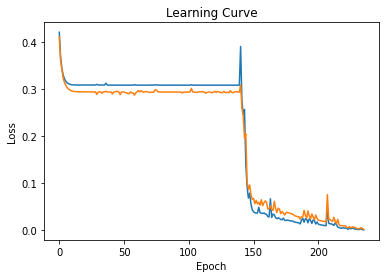

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

final_model, criterion, optimizer = create_net_loss_optim(best_params["hiddensize"],
                                                          best_params["num_hidden_layer"],
                                                          best_params["optimizer"].lower(),
                                                          best_params["lr"],
                                                          best_params["momentum"],
                                                          )
losses, vallosses, _, final_model = _train(x_train, y_train, criterion, optimizer, final_model)

plt.plot(losses)
plt.plot(vallosses)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Test the final model on train and test sets

MSE on Training Set = 0.0008145284373313189
MSE on Test Set = 0.0022407539654523134


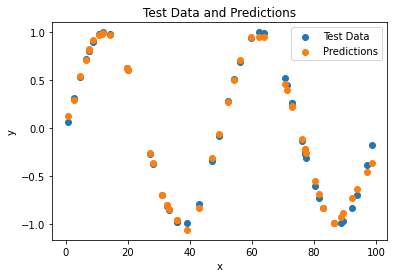

In [ ]:
# Test the neural network with train data ---------------------
with torch.no_grad():
    y_pred = final_model(x_train) # make a forward pass on the train data

loss = criterion(y_pred, y_train) # calculate the loss
print("MSE on Training Set = {}".format(loss.item()))

#lets see the generalization error ----------------------------
# Test the neural network with val data
with torch.no_grad():
    y_pred = final_model(x_test) # make a forward pass on the test data

valloss = criterion(y_pred, y_test) # calculate the loss
print("MSE on Test Set = {}".format(valloss.item()))

# Plot the test data & predictions -----------------------------
plt.scatter(x_test.numpy(), y_test.numpy(), label='Test Data')
plt.scatter(x_test.numpy(), y_pred.numpy(), label='Predictions')

plt.title("Test Data and Predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()